## Thing to do

```bash
(1) CNN Construct
(last) Visualize x_hat with 8X8 comparing with x and x_hat
```

## 2022S Student Project: Deep Supervised Learning for MRI Reconstruction

### [0]Necessary Module
```bash
conda install h5py : dataset compatibility
conda install tqdm : Track the training process
```

In [28]:
import numpy as np
import h5py

In [29]:
with h5py.File('C:/Users/pyiph/Desktop/CIG Project/dataset.hdf5', 'r') as hdf:
    ls = list(hdf.keys())
    # Check the dataset structure
    print('List of datasets in this file: \n', ls)
    
    # Get ground-truth(trnOrg)
    x = hdf.get('trnOrg')
    # Get Sampling operator(trnMask)
    p = hdf.get('trnMask')
    
    # Test ground-truth
    tX = hdf.get('tstOrg')
    # Test Sampling operator
    tP = hdf.get('tstMask')
    
    '''Get the corresponding array
    xArray.shape: (360, 256, 232)
    pArray.shape: (360, 256, 232)
    '''
    xArray = np.array(x)
    pArray = np.array(p)
    
    tXArray = np.array(tX)
    tPArray = np.array(tP)

List of datasets in this file: 
 ['trnCsm', 'trnMask', 'trnOrg', 'tstCsm', 'tstMask', 'tstOrg']


### [1] Obtain y and x_hat 



P: `Sampling operator` (pArray)

F: `Fourier transform`

e: in this project we will `set it as zero`



C:\Users\pyiph\AppData\Local\Temp/ipykernel_4264/2574344557.py:17: ComplexWarning: Casting complex values to real discards the imaginary part
  xArray = xArray.astype(float)
C:\Users\pyiph\AppData\Local\Temp/ipykernel_4264/2574344557.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  xHat = xHat.astype(float)


Text(0.5, 1.0, 'X Hat')

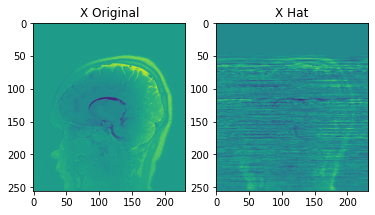

In [30]:
import numpy as np
from matplotlib import pyplot as plt

# initialize yArray / xHat
#yArray = np.zeros(xArray.shape)
#xHat = np.zeros(xArray.shape)
eValue = 0

yArray = pArray*np.fft.fft(xArray) + eValue
xHat = np.fft.ifft(yArray)

# Testset operation
tYArray = tPArray*np.fft.fft(tXArray) + eValue
tXHat = np.fft.ifft(tYArray)


xArray = xArray.astype(float)
xHat = xHat.astype(float)
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
imgplot = plt.imshow(xArray[0])
ax.set_title('X Original')
ax = fig.add_subplot(1, 2, 2)
imgplot = plt.imshow(xHat[0])
ax.set_title('X Hat')

## [3] Model Training

### [3-1] Data split (Train / Validation / Test)

In [31]:
import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import train_test_split
#from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

xArray = torch.from_numpy(xArray)
xHat = torch.from_numpy(xHat)
tXArray = torch.from_numpy(tXArray)
tXHat = torch.from_numpy(tXHat)

# Train/Validation/Test: 69% / 20%/ 11%
data_val, data_test, labels_val, labels_test = train_test_split(tXHat, tXArray, test_size=0.36, random_state=42)

#trainDataset = TensorDataset(xHat, xArray)
trainDataset = TensorDataset(xArray, xHat)
valDataset = TensorDataset(data_val, labels_val)
testDataset = TensorDataset(data_test, labels_test)

trainDataLoader = DataLoader(trainDataset, batch_size=8, shuffle = True)
valDataLoader = DataLoader(valDataset, batch_size=1, shuffle = True)
testDataLoader = DataLoader(testDataset, batch_size=1, shuffle = False)

### [3-2] CNN(Convolutional Neural Network)

Input: xHat

Output: xArray


```bash


```

<!--

##### Reference Paper: RARE: Image Reconstruction using Deep Priors Learned without Groundtruth

![20220617_222458.png](attachment:20220617_222458.png)

![20220617_222201.png](attachment:20220617_222201.png)
-->

### [3-3] CNN - Residual Structure

In [32]:
import torch.nn as nn
import torch.nn.functional as F

kernel_size = 3

class DnCNN(torch.nn.Module):
    class Block(torch.nn.Module):
        def __init__(self, n_input, n_output, stride=1):
            super().__init__()
            self.net = torch.nn.Sequential(
            torch.nn.Conv2d(n_input, n_output, kernel_size = kernel_size, padding = (int) (kernel_size / 2), stride = stride, bias = False),
            torch.nn.BatchNorm2d(n_output),
            torch.nn.ReLU(),
            torch.nn.Conv2d(n_output, n_output, kernel_size = kernel_size, padding = (int) (kernel_size / 2), bias = False),
            torch.nn.BatchNorm2d(n_output),
            torch.nn.ReLU()
            )
            self.downsample = None
            if stride != 1 or n_input != n_output:
                self.downsample = torch.nn.Sequential(torch.nn.Conv2d(n_input, n_output, kernel_size = kernel_size, padding = (int) (kernel_size / 2), stride = stride, bias = False),
                                                      torch.nn.BatchNorm2d(n_output))
        def forward(self, x):
            identity = x
            if self.downsample is not None:
                identity = self.downsample(x)
            return self.net(x) + identity
    
    def __init__(self, channels=1):
        super().__init__()
        features = 64
        L = [torch.nn.Conv2d(in_channels=channels, out_channels=features, kernel_size=kernel_size, padding=(int) (kernel_size / 2), bias=False),
             torch.nn.BatchNorm2d(features),
             torch.nn.ReLU()
            ]
        numberOfResBlock = 3
        
        for l in range(numberOfResBlock):
            L.append(self.Block(features, features))
         
        L.append(torch.nn.Conv2d(in_channels=features, out_channels=channels, kernel_size=kernel_size, padding=(int) (kernel_size / 2)))
        self.network = torch.nn.Sequential(*L)
         
    def forward(self, x):
        out = self.network(x)
        return out

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Check the GPU Availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [34]:
# To refresh gpu cache
import gc
gc.collect()
torch.cuda.empty_cache()

### [3-4] Deep Neural Network Model - Training

In [35]:
# Initial training
model = DnCNN().to(device)
# Pre-trained model training
#model = torch.load("C:/Users/pyiph/Desktop/CIG Project/model/model1")

loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

epochs = 15

for epoch in range(epochs):
    model.train()
    lossTrain = []
    lossVal = []
    for ii, (data, label) in enumerate(trainDataLoader):
        data, label = data.to(device).float(), label.to(device).float()

        # Reshape the datasize
        data = data.view(-1, 1, xArray.shape[1], xArray.shape[2])
        label = label.view(-1, 1, xArray.shape[1], xArray.shape[2])

        # Produce model output
        #output = model(data.unsqueeze(1))
        output = model(data)

        # compute the loss and accuracy
        loss = loss_function(output, label)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        cnn_output = np.squeeze(output.cpu().detach().numpy())

        lossTrain.append(loss.item())

    with torch.no_grad():
        model.eval()
        for vii, (vData, vLabel) in enumerate(valDataLoader):
            vData, vLabel = vData.to(device).float(), vLabel.to(device).float()
            # Reshape the datasize
            vData = vData.view(-1, 1, xArray.shape[1], xArray.shape[2])
            vLabel = vLabel.view(-1, 1, xArray.shape[1], xArray.shape[2])

            val_output = model(vData)
            val_loss = loss_function(val_output, vLabel)
            lossVal.append(val_loss.item())

    # print avg training statistics 
    avgTrainLoss = sum(lossTrain)/len(lossTrain)
    avgValLoss = sum(lossVal)/len(lossVal)

    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, 
        avgTrainLoss,
        avgValLoss
        ))

Epoch: 0 	Training Loss: 0.834804 	Validation Loss: 0.033070
Epoch: 1 	Training Loss: 0.013638 	Validation Loss: 0.022086
Epoch: 2 	Training Loss: 0.009065 	Validation Loss: 0.019010
Epoch: 3 	Training Loss: 0.006851 	Validation Loss: 0.018102
Epoch: 4 	Training Loss: 0.005746 	Validation Loss: 0.016866
Epoch: 5 	Training Loss: 0.005056 	Validation Loss: 0.016517
Epoch: 6 	Training Loss: 0.004453 	Validation Loss: 0.016265
Epoch: 7 	Training Loss: 0.004187 	Validation Loss: 0.015480
Epoch: 8 	Training Loss: 0.004012 	Validation Loss: 0.015441
Epoch: 9 	Training Loss: 0.003874 	Validation Loss: 0.015088
Epoch: 10 	Training Loss: 0.003580 	Validation Loss: 0.015443
Epoch: 11 	Training Loss: 0.003542 	Validation Loss: 0.015020
Epoch: 12 	Training Loss: 0.003361 	Validation Loss: 0.015004
Epoch: 13 	Training Loss: 0.003498 	Validation Loss: 0.014853
Epoch: 14 	Training Loss: 0.003344 	Validation Loss: 0.014815


### [3-5] Deep Neural Network Model - Model Saving

In [11]:
rootDirectory = "C:/Users/pyiph/Desktop/CIG Project/model/"

torch.save(model, rootDirectory + "model10")

## [4] Output of testset

In [37]:
model = torch.load("C:/Users/pyiph/Desktop/CIG Project/model/model1")

### [4-1] Evaluation of PSNR and SSIM

In [38]:
# Module to estimate PSNR and SSIM
import kornia

model.eval()
#print(model.training)

with torch.no_grad():
    model.eval()
    psnrLossList = []
    ssimLossList = []
    for tii, (tData, tLabel) in enumerate(testDataLoader):
        tData, tLabel = tData.to(device).float(), tLabel.to(device).float()
        # Reshape the datasize
        tData = tData.view(-1, 1, xArray.shape[1], xArray.shape[2])
        tLabel = tLabel.view(-1, 1, xArray.shape[1], xArray.shape[2])
        test_output = model(tData)
        
        psnr_loss = kornia.metrics.psnr(test_output, tLabel, 1.0)
        ssim_value = kornia.metrics.psnr(test_output, tLabel, 1.0)

        psnrLossList.append(psnr_loss)
        ssimLossList.append(ssim_loss.item())

    # print avg training statistics 
    avgPsnrLoss = sum(psnrLossList)/len(psnrLossList)
    avgSsimLoss = sum(ssimLossList)/len(ssimLossList)

print(f"Average PSNR Loss: {avgPsnrLoss}")
print(f"Average SSIM Loss: {avgSsimLoss}")

Average PSNR Loss: 23.29644775390625
Average SSIM Loss: 0.3511001169681549


### [4-2] Visualizing test result

C:\Users\pyiph\AppData\Local\Temp/ipykernel_4264/1627191535.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


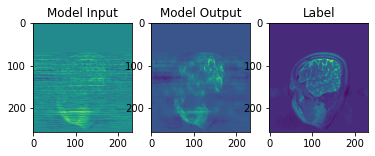

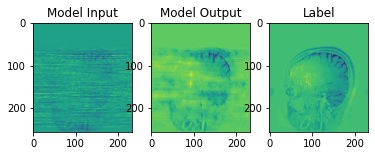

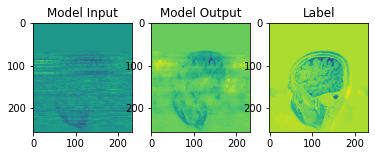

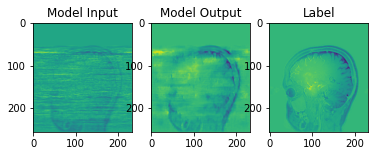

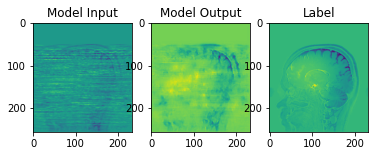

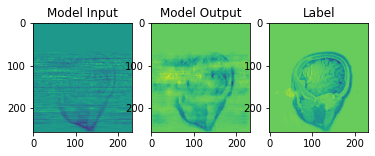

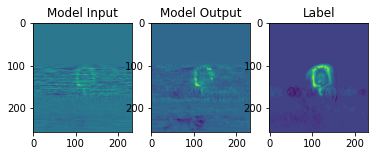

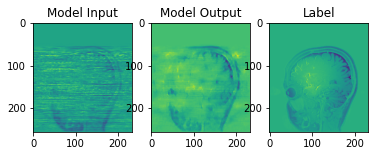

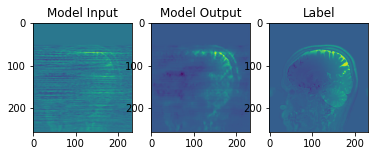

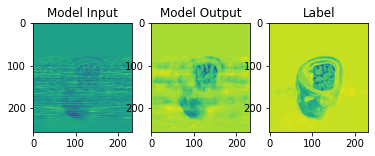

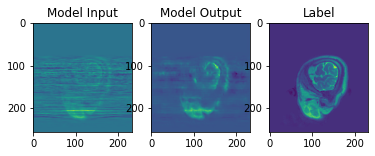

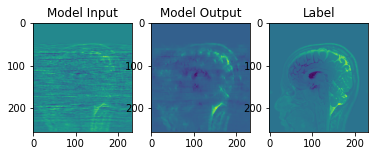

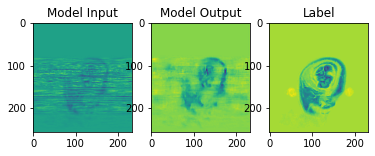

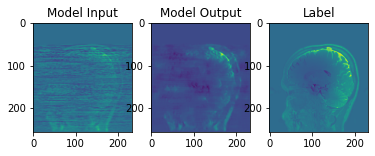

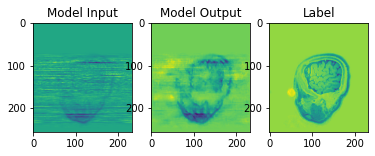

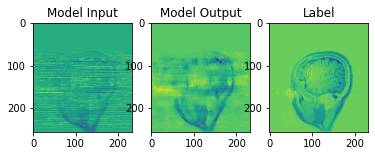

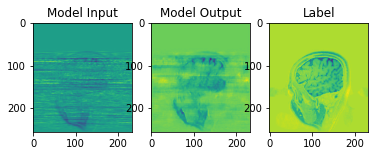

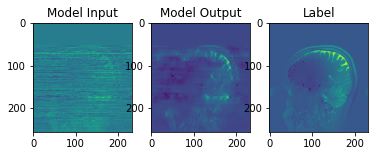

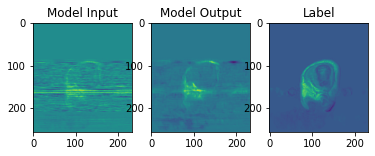

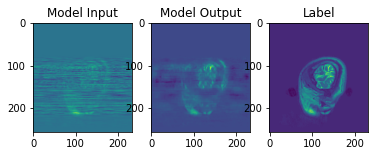

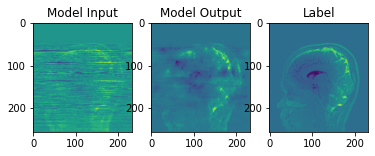

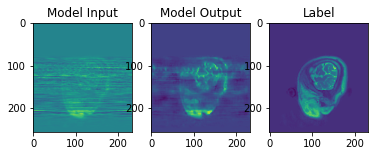

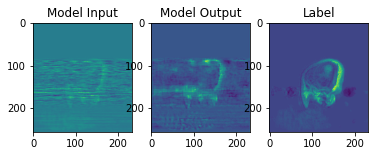

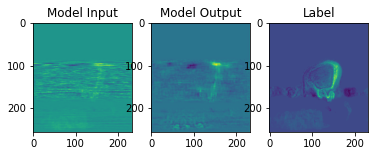

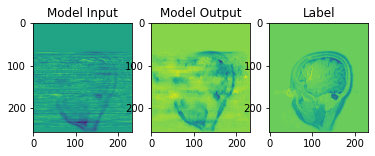

In [39]:
# Input : tXHat
# Output: Model(tXHat)
with torch.no_grad():
    model.eval()
    i = 0
    for tii, (tData, tLabel) in enumerate(testDataLoader):
        tData, tLabel = tData.to(device).float(), tLabel.to(device).float()
        # Reshape the datasize
        tData = tData.view(-1, 1, xArray.shape[1], xArray.shape[2])
        tLabel = tLabel.view(-1, 1, xArray.shape[1], xArray.shape[2])

        test_output = model(tData)
        

        fig = plt.figure()
        ax = fig.add_subplot(1, 3, 1)
        imgplot = plt.imshow(tData[0][0].cpu())
        ax.set_title('Model Input')
        ax = fig.add_subplot(1, 3, 2)
        imgplot = plt.imshow(test_output[0][0].cpu())
        ax.set_title('Model Output')
        ax = fig.add_subplot(1, 3, 3)
        imgplot = plt.imshow(tLabel[0][0].cpu())
        ax.set_title('Label')
        
        i += 1
        
        if i == 25:
            break